In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Load your dataset
df = pd.read_csv("C:\\Users\\msa72\\Downloads\\combined_network_data.csv")


# Preprocessing
attacks = ['BenignTraffic', 'Mirai-greeth_flood', 'Mirai-greip_flood', 'Mirai-udpplain']
df = df[df['label'].isin(attacks)]
df.drop_duplicates(inplace=True)
df.fillna(0, inplace=True)
X = df.drop(['label'], axis=1)
y = df['label']

# Encode the labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Split the dataset into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Create the base models
knn = KNeighborsClassifier(n_neighbors=5)
rf = RandomForestClassifier(n_estimators=100, random_state=42)
dt = DecisionTreeClassifier(random_state=42)

# Create the stacking classifier
estimators = [
    ('knn', knn),
    ('rf', rf),
    ('dt', dt)
]

stacking_model = StackingClassifier(
    estimators=estimators,
    final_estimator=RandomForestClassifier(n_estimators=100, random_state=42)
)

# Fit the stacking model on the training data
stacking_model.fit(X_train, y_train)

# Make predictions on the validation set
stacking_predictions_val = stacking_model.predict(X_val)

# Calculate the accuracy of the stacking model on the validation set
accuracy_val = accuracy_score(y_val, stacking_predictions_val)

# Print the accuracy on the validation set
print(f"Stacking Model Accuracy on Validation Set: {accuracy_val * 100:.2f}%")

# Make predictions on the test set
stacking_predictions_test = stacking_model.predict(X_test)

# Calculate the accuracy of the stacking model on the test set
accuracy_test = accuracy_score(y_test, stacking_predictions_test)

# Print the accuracy on the test set
print(f"Stacking Model Accuracy on Test Set: {accuracy_test * 100:.2f}%")


Stacking Model Accuracy on Validation Set: 99.84%
Stacking Model Accuracy on Test Set: 99.88%


In [2]:
#1. Model Performance Evaluation
attack_specific_metrics_test = classification_report(
    y_test,
    stacking_predictions_test,
    labels=label_encoder.transform(attacks),
    target_names=attacks
)

print("\nModel Performance Evaluation:")
print(attack_specific_metrics_test)


Model Performance Evaluation:
                    precision    recall  f1-score   support

     BenignTraffic       1.00      1.00      1.00      1981
Mirai-greeth_flood       1.00      1.00      1.00      1846
 Mirai-greip_flood       1.00      1.00      1.00      1429
    Mirai-udpplain       1.00      1.00      1.00      1673

          accuracy                           1.00      6929
         macro avg       1.00      1.00      1.00      6929
      weighted avg       1.00      1.00      1.00      6929




False Positive Rate (FPR) and False Negative Rate (FNR) Analysis on Test Set:
BenignTraffic: FPR=0.0006, FNR=0.0005
Mirai-greeth_flood: FPR=0.0007, FNR=0.0022
Mirai-greip_flood: FPR=0.0022, FNR=0.0007
Mirai-udpplain: FPR=0.0010, FNR=0.0012


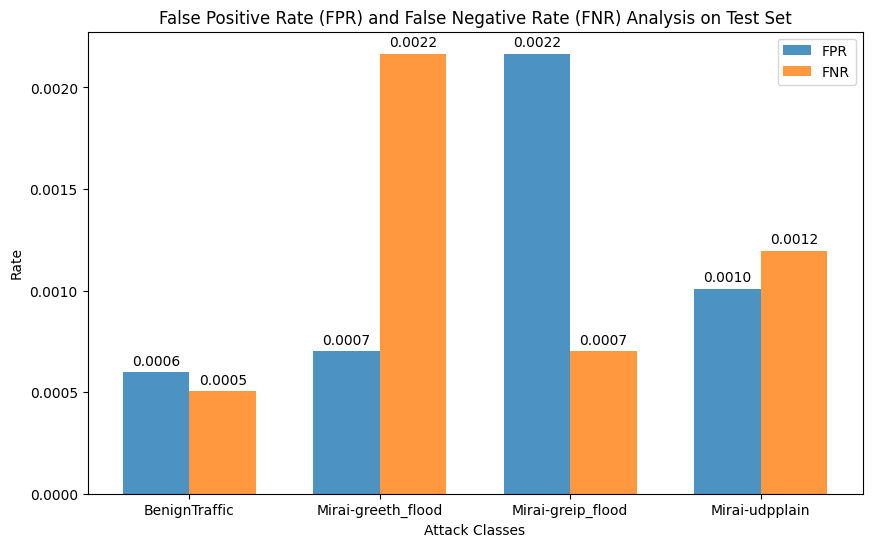

In [4]:
#2. False Positive and Negative Analysis
import matplotlib.pyplot as plt

confusion_test = confusion_matrix(y_test, stacking_predictions_test)

fpr_per_class_test = {}
fnr_per_class_test = {}

for i, attack in enumerate(attacks):
    true_positives = confusion_test[i, i]
    false_positives = confusion_test[:, i].sum() - true_positives
    false_negatives = confusion_test[i, :].sum() - true_positives
    true_negatives = confusion_test[~i, ~i].sum()

    fpr = false_positives / (false_positives + true_negatives)
    fnr = false_negatives / (false_negatives + true_positives)

    fpr_per_class_test[attack] = fpr
    fnr_per_class_test[attack] = fnr

# Print FPR and FNR for each class on the test set
print("\nFalse Positive Rate (FPR) and False Negative Rate (FNR) Analysis on Test Set:")
for attack in attacks:
    print(f"{attack}: FPR={fpr_per_class_test[attack]:.4f}, FNR={fnr_per_class_test[attack]:.4f}")

# Bar chart
# Extract FPR and FNR values
fpr_values_test = [fpr_per_class_test[attack] for attack in attacks]
fnr_values_test = [fnr_per_class_test[attack] for attack in attacks]

# Bar chart
fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.35
index = range(len(attacks))

bar1 = ax.bar(index, fpr_values_test, bar_width, label='FPR', alpha=0.8)
bar2 = ax.bar([i + bar_width for i in index], fnr_values_test, bar_width, label='FNR', alpha=0.8)

# Labeling
ax.set_xlabel('Attack Classes')
ax.set_ylabel('Rate')
ax.set_title('False Positive Rate (FPR) and False Negative Rate (FNR) Analysis on Test Set')
ax.set_xticks([i + bar_width / 2 for i in index])
ax.set_xticklabels(attacks)
ax.legend()

# Display the values on top of the bars
def autolabel(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.4f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords='offset points',
                    ha='center', va='bottom')

autolabel(bar1)
autolabel(bar2)

plt.show()

In [6]:
#3. Robustness and Sensitivity Testing
import numpy as np

# Function to add noise to the data
def add_noise(data, noise_level=0.001):
    noise = np.random.normal(0, noise_level, data.shape)
    noisy_data = data + noise
    return noisy_data

# Function to filter out noise from the data
def filter_noise(data, threshold=0.001):
    filtered_data = np.where(np.abs(data) < threshold, 0, data)
    return filtered_data


# Original model accuracy on the original test set
stacking_predictions_original = stacking_model.predict(X_test)
accuracy_original = accuracy_score(y_test, stacking_predictions_original)
print(f"Original Model Accuracy on Test Set: {accuracy_original * 100:.2f}%")

# Evaluate model accuracy after adding noise
noisy_X_test = add_noise(X_test)
stacking_predictions_noisy = stacking_model.predict(noisy_X_test)
accuracy_noisy = accuracy_score(y_test, stacking_predictions_noisy)
print(f"Model Accuracy on Noisy Test Set: {accuracy_noisy * 100:.2f}%")

# Evaluate model accuracy after filtering out noise
filtered_X_test = filter_noise(noisy_X_test)
stacking_predictions_filtered = stacking_model.predict(filtered_X_test)
accuracy_filtered = accuracy_score(y_test, stacking_predictions_filtered)
print(f"Model Accuracy on Filtered Test Set: {accuracy_filtered * 100:.2f}%")

Original Model Accuracy on Test Set: 99.88%
Model Accuracy on Noisy Test Set: 95.01%
Model Accuracy on Filtered Test Set: 95.01%
